In [1]:
# 2018-03-20
# A. Pendleton
# Calculating Trinity Statistics

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [3]:
def get_sample_info():
    #Reading in the RNA-Seq library IDs
    sampleInfo = '/home/ampend/links/kidd-lab/ampend-projects/Novel_Sequence_Analysis/rna-seq/SampleInfoTable.txt'
    sampleDict, tissueDict, samples = {}, {}, []

    for line in open(sampleInfo, 'r'):
        if 'Bio' in line: #skips header
            continue
        line=line.rstrip().split()
        ID = line[4]
        #Rename some tissues to shorter name
        tissue = line[5]
        
        if 'SmoothMuscle' in tissue:
            shortTissue = 'SM'
        if 'Unidentified' in tissue:
            shortTissue = 'NA'
        if 'Blood' in tissue:
            shortTissue = 'BL'
        if 'Brain' in tissue:
            shortTissue = 'BR'
        if 'Heart' in tissue:
            shortTissue = 'HT'
        if 'Ovary' in tissue:
            shortTissue = 'OV'
        if 'Skin' in tissue:
            shortTissue = 'SK'
        if 'Kidney' in tissue:
            shortTissue = 'KD'
        if 'Testis' in tissue:
            shortTissue = 'TS'
        if 'Liver' in tissue:
            shortTissue = 'LV'
        if 'Lung' in tissue:
            shortTissue = 'LG'
        sampleDict[ID] = []
        sampleDict[ID].append(tissue)
        sampleDict[ID].append(shortTissue)
        samples.append(ID)
        

        
        if tissue not in tissueDict.keys():
            tissueDict[tissue] = []
        tissueDict[tissue].append(ID)

    print('%i samples added to a sample array from the following tissues:\n' % len(samples))

    genomes = ['zoey-2.3','canFam3.1-noY']

    for tissue in tissueDict.keys():
        print(tissue)

    return sampleDict, tissueDict, genomes


# Reading in library information


In [4]:
#Reading in library information
sampleDict, tissueDict, genomes = get_sample_info()

samples=[]
for key in sampleDict.keys():
    samples.append(key)

42 samples added to a sample array from the following tissues:

Liver
Brain
Heart
Kidney
Ovary
Lung
Testis
Unidentified
SmoothMuscle
Skin
Blood


# Reading in ALL Trinity de novo transcripts


In [5]:
trinDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/no-genome-guided/AllLibraries_trinity/'

In [6]:
fastaFile = open(trinDir + 'Trinity.fasta')
deNovoDict = {} #to keep track of each Trinity de novo transcript
DictHeaders = [] #to keep track of what data is in each column of the dictionary

for line in fastaFile:
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        length = int(line[1].split('=')[1])
    else:
        continue
    deNovoDict[ID] = []
    deNovoDict[ID].append(length)
    
fastaFile.close()

print('%i de novo transcripts saved to dictionary' % len(deNovoDict.keys()))

#Keep track of dictionary columns added in this cell:
DictHeaders.append('Length (bp)')


886898 de novo transcripts saved to dictionary


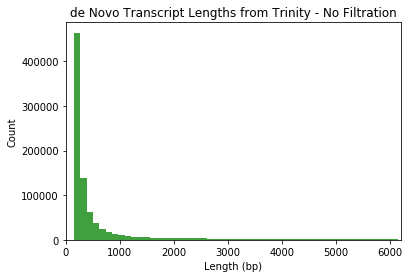

UNFILTERED TRINITY TRANSCRIPTS: Minimum transcript length =  151
UNFILTERED TRINITY TRANSCRIPTS: Maximum transcript length =  58984
UNFILTERED TRINITY TRANSCRIPTS: Mean transcript length =  716.204878126
UNFILTERED TRINITY TRANSCRIPTS: Median transcript length =  258.0


In [8]:
lengths = []

for key in deNovoDict.keys():
    transcriptLength = deNovoDict[key][0]
    lengths.append(transcriptLength)

_ = plt.hist(lengths, 500, facecolor='green', alpha=0.75)
plt.title('de Novo Transcript Lengths from Trinity - No Filtration' )
plt.xlabel('Length (bp)')
plt.ylabel('Count')
plt.xlim(0,6200)
plt.show()

print('UNFILTERED TRINITY TRANSCRIPTS: Minimum transcript length = ', min(lengths))
print('UNFILTERED TRINITY TRANSCRIPTS: Maximum transcript length = ', max(lengths))
print('UNFILTERED TRINITY TRANSCRIPTS: Mean transcript length = ', np.mean(lengths))
print('UNFILTERED TRINITY TRANSCRIPTS: Median transcript length = ', np.median(lengths))

### Keep track of whether or not the transcript remained following clustering with CD-HIT-EST

In [9]:
#path to CD-HIT-EST results on unfiltered Trinity de novo transcripts
cdHitDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/CD-HIT/results/'

#Levels of c thresholds used to do the % identity clustering using CD-HIT-EST
cValues = [1,99,98]
#Add default 'False' values for next three indices representing each of the three c values
for key in deNovoDict.keys():
    deNovoDict[key].append('False') #c=100%
    deNovoDict[key].append('False') #c=99%
    deNovoDict[key].append('False') #c=98%


#Read through fasta file resulting from each of the three filtrations (c-values)
#   where if a fasta identifier is in this file, then it passed clustering filtration by CD-HIT-EST

################################################################################################
#c = 100%
inFile = cdHitDir + 'Trinity_c1.out' 
print('\n##C value = ', 100)
passCount = 0

for line in open(inFile,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        deNovoDict[key][1] = True    
        passCount+=1
    else:
        continue
print('Processed %i transcripts that passed at this c-value' % (passCount))

################################################################################################
#c = 99%
inFile = cdHitDir + 'Trinity_c99.out' 
print('\n##C value = ', 99)
passCount = 0

for line in open(inFile,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        deNovoDict[key][2] = True 
        passCount+=1
    else:
        continue
print('Processed %i transcripts that passed at this c-value' % (passCount))

################################################################################################
#c = 98%
inFile = cdHitDir + 'Trinity_c98.out' 
print('\n##C value = ', 98)
passCount = 0

for line in open(inFile,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        deNovoDict[key][3] = True    
        passCount+=1
    else:
        continue
print('Processed %i transcripts that passed at this c-value' % (passCount))

################################################################################################
    
#Keep track of dictionary columns added in this cell:
DictHeaders.append(['Remains after 100% ID filtration (CD-HIT-EST) (T/F)','Remains after 99% ID filtration (CD-HIT-EST) (T/F)','Remains after 98% ID filtration (CD-HIT-EST) (T/F)'])



##C value =  100
Processed 886681 transcripts that passed at this c-value

##C value =  99
Processed 872848 transcripts that passed at this c-value

##C value =  98
Processed 863785 transcripts that passed at this c-value


### What expression support from the 42 libraries was observed for each transcript?

In [7]:
samples = []
for key in sampleDict.keys():
    samples.append(key)
print(samples.index('SRR388757'))

24


In [92]:
#Root directory for the RSEM/RNA-Seq assessment for TPM per transcript
rootDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/no-genome-guided/AllLibraries_trinity/AlignmentAssessment/Unfiltered_Trinity/'

RNASeqDict,RNASeqDictHeaders = {}, []
perSampleCounts = []

#Create a new dictionary where it's all the same keys where keys = raw unfiltered de novo transcripts
for key in deNovoDict.keys():
    RNASeqDict[key] = []


for sample in sampleDict.keys():
    print('\n#SAMPLE: ', sample, ' -- ', sampleDict[sample][0])
    #Clear variables per sample to keep track of how many transcripts are in file, versus how many have expression support
    exp_isoformCount, isoformCount = 0,0 
    
    #Define input files
    inDir = rootDir + sample + '/' #storing the information for each 
    isoformFile = inDir + 'RSEM.isoforms.results'
    
    #Add the sample ID to the header to keep track of which sample applies to each index
    RNASeqDictHeaders.append(sample)
    
    #Now save expression data for this library to the dictionary
    for line in open(isoformFile,'r'):
        if 'transcript' in line: #skips header
            continue
        line = line.rstrip().split()
        isoformID, effectiveLength, TPM, FPKM, IsoPct = line[0],int(line[2]),float(line[5]),float(line[6]),float(line[7])
        RNASeqDict[isoformID].append([effectiveLength, TPM, FPKM, IsoPct])
        #keep track of how many isoforms we processed, versus how many have TPM > 1.0
        isoformCount += 1
        if TPM > 1.0:
            exp_isoformCount += 1

    print('%s: %i/%i transcripts with RNA-Seq support TPM > 1.0' % (sample,exp_isoformCount,isoformCount))
    perSampleCounts.append([sample,sampleDict[sample][0],sampleDict[sample][1],exp_isoformCount])
print('DONE!')


#SAMPLE:  SRR388739  --  Unidentified
SRR388739: 44688/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR543735  --  Kidney
SRR543735: 38977/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR536884  --  Skin
SRR536884: 39822/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR536883  --  Brain
SRR536883: 54229/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388736  --  Liver
SRR388736: 35578/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388754  --  Lung
SRR388754: 52977/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388740  --  Brain
SRR388740: 55730/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388738  --  Skin
SRR388738: 45487/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388759  --  Unidentified
SRR388759: 44597/886898 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR536882  --  Kidney
SRR536882: 38720/886898 transcripts with RNA-Seq support TPM > 1

## How many transcripts have expression support in at least one tissue

In [95]:
anyExpression,noExpression,threeSupport = 0, 0, 0 
libraryCounts = []

outFile = open(trinDir + 'PerLibrary_RNASupport_PerTrinityDeNovoTranscript.txt','w')
#Write header
outFile.write('Transcript ID\tLength (bp)\tCD-HIT 100% (T/F)\tCD-HIT (99%) (T/F)\tCD-HIT (98%) (T/F)\t')
for i in range(0,len(samples)):
    outFile.write('%s\t' % samples[i])
outFile.write('Libraries With Expression (out of 42)\n')

#Write out per isoform information
for isoformID in RNASeqDict:
    if len(RNASeqDict[isoformID]) == 0:
        continue
    #keep track how many RNA-Seq libraries (out of 42) have expression >1.0
    libraryExpCount = 0
    for i in range(0,len(RNASeqDict[isoformID])):
        #WRITE LENGTH IN BP ONLY FOR FIRST LIBRARY = INDEX==0
        if i == 0:
            length = RNASeqDict[isoformID][0][0]
            cd1,cd99,cd98 = deNovoDict[isoformID][1],deNovoDict[isoformID][2],deNovoDict[isoformID][3]
            outFile.write('%s\t%s\t%s\t%s\t%s\t' % (isoformID,length,cd1,cd99,cd98))
        #WRITE EXPRESSION DATA 
        TPM, FPKM, IsoPct = RNASeqDict[isoformID][i][1],RNASeqDict[isoformID][i][2],RNASeqDict[isoformID][i][3] 
        outFile.write('%.2f:%.2f:%.2f\t' % (TPM, FPKM, IsoPct))
        if TPM > 1.0:
            libraryExpCount += 1
    #Now that each datapoint has been entered, write how many libraries had expression support and write a new line
    outFile.write('%i\n'%libraryExpCount)
    
    #Keep track of how many had library support
    if libraryExpCount > 0:
        anyExpression += 1
        if libraryExpCount > 2:
            threeSupport += 1
    else:
        noExpression += 1
    libraryCounts.append(libraryExpCount)

outFile.close()

print('%i isoforms had zero transcript support' % noExpression)
print('%i isoforms had transcript support in at least one library' % anyExpression)
print('%i isoforms had transcript support in at least THREE libraries' % threeSupport)

print('Average number of libraries per support == ', np.mean(libraryCounts))
print('Range of library support = %i-%i' % (min(libraryCounts),max(libraryCounts)))

472047 isoforms had zero transcript support
414851 isoforms had transcript support in at least one library
184015 isoforms had transcript support in at least THREE libraries
Average number of libraries per support ==  2.07152118958
Range of library support = 0-42


### ###################################################
### Plotting per tissue  transcript counts with FPKM > 1.0 per library

In [21]:

#SAVE AS DATAFRAME, TRANSPOSE, SORT BY TISSUE
tDict = pd.DataFrame(perSampleCounts)
tDict.columns = ['Sample','Tissue','Tissue Code','Isoform Count']
zoey_tDict_sort = tDict.sort_values(by=['Tissue','Sample'])
zoey_tDict_sort = tDict_sort.set_index('Sample')
zoey_tDict_sort.head()




,Tissue,Tissue Code,Isoform Count
Sample,,,
SRR388749,Blood,BL,29267
SRR388753,Blood,BL,28865
SRR388757,Blood,BL,28976
SRR388737,Brain,BR,55629
SRR388740,Brain,BR,55730


"plotDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/plots/'\nplotFile = plotDir + 'LibraryCufflinksTranscriptCounts_n10n1.pdf'\nplt.savefig(plotFile,transparent=True,bbox_inches = 'tight') #save\n\nsimpleaxis(ax)\nplt.show()"

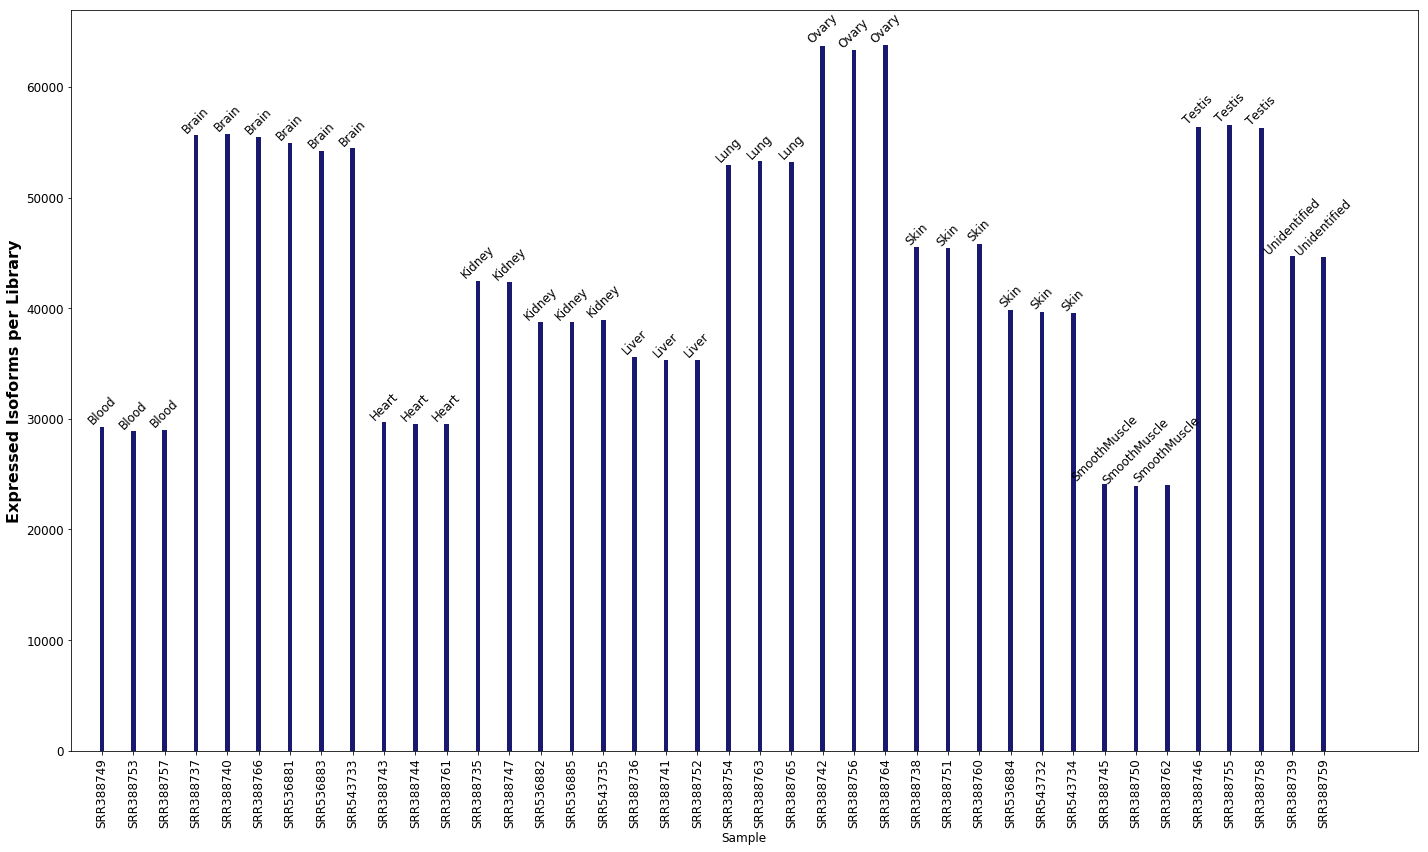

In [26]:
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
plt.ylabel('Expressed Isoforms per Library',fontweight="bold",fontsize=16)
tDict_sort['Isoform Count'].plot(kind='bar', color='midnightblue', ax=ax, width=0.15, align='center')
ax.set_xlim(-1, 42) #adds extra white space between first bar and y-axis

# Add tissue labels to the column pairs
rects = ax.patches
labels = tDict_sort['Tissue'] #get the labels 
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom',rotation=45)

plt.tight_layout()
"""plotDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/plots/'
plotFile = plotDir + 'LibraryCufflinksTranscriptCounts_n10n1.pdf'
plt.savefig(plotFile,transparent=True,bbox_inches = 'tight') #save

simpleaxis(ax)
plt.show()"""


In [99]:
####################################################################################
####################################################################################
####################################################################################

# Now we are parsing the BLAT results where each transcript was aligned to the 
#   canFam3.1-Y and zoey-2.3 genomes

####################################################################################
####################################################################################
####################################################################################

# Parsing de novo transcript BLAT results

In [74]:
BLATDir = '/home/ampend/links/kidd-lab-scratch/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/no-genome-guided/AllLibraries_trinity/BLAT/'

blatDict = {}
#Stats for quality of alignments per genome
zoeySingle,zoeyMulti = 0,0
canfamSingle,canfamMulti = 0,0

#Keeping track of the transcripts that don't align to a genome:
noHitFile = open(BLATDir + 'NoHits.txt','w')

for genome in genomes:
    #to keep track of what's already been parsed:
    parsedIDs,multi_hits = [], [] #all hits
    transcript_count = 0 
    
    #Define path to input files
    inDir = BLATDir + genome + '/'
    for i in range(1,89):
        inFile = inDir + 'BLAT_%s_Trinity_%i.psl' % (genome,i)
        lineCount = 0
        noAlignment = [] #for transcripts that dont have strong alignment anywhere
        HITS,MULTI = 0 ,0
        for line in open(inFile,'r'):
            line=line.rstrip().split()
            lineCount += 1
            
            
            #Skip if line number is less than the 6th line, becuase that's where the data starts
            if lineCount < 6:
                continue

            #read line data
            match, strand, transcriptID = int(line[0]), line[8], line[9]
            chrom,start,end = line[13],int(line[15]),int(line[16])
            
            transcriptLength = int(line[10])
            propHit = match/float(transcriptLength)
            
            #only accept hits with >90% alignment
            if propHit < .9:
                #if the transcript hasn't been seen before in any other 
                if transcriptID not in blatDict.keys() and transcriptID not in noAlignment:
                    noAlignment.append(transcriptID)
                    noHitFile.write('%s\t%s\n' % (transcriptID,genome))
                continue

            #If this transcript hasn't been seen before, create new dictionary structure to store
            # both zoey and canfam hits:
            if transcriptID not in blatDict.keys():
               #blatDict[transcriptID] =  #0-transcriptID,1-zoey_chrom,2-zoey_start,3-zoey_end,4-zoey_transcriptLength,
               #                          #5-zoey_match,6-zoey_alignmentNum,
               #                          #7- cf_chrom, 8-cf_start, 9-cf_end, 10-cf_transcriptLength, 
               #                          #11-cf_match, 12-cf_alignmentNum
                blatDict[transcriptID] = []
                blatDict[transcriptID] = [transcriptID,'','','','','','','','','','','','']
                
            #If not already in the array, this is the top hit!
            if transcriptID not in parsedIDs:
                parsedIDs.append(transcriptID)
                hits.append(transcriptID)
                if 'zoey' in genome:
                    blatDict[transcriptID][1],blatDict[transcriptID][2],blatDict[transcriptID][3] = chrom, start, end
                    blatDict[transcriptID][4],blatDict[transcriptID][5],blatDict[transcriptID][6] = transcriptLength, match, 1
                if 'canFam3.1' in genome:
                    blatDict[transcriptID][7],blatDict[transcriptID][8],blatDict[transcriptID][9] = chrom, start, end
                    blatDict[transcriptID][10],blatDict[transcriptID][11],blatDict[transcriptID][12] = transcriptLength, match, 1
                HITS += 1
            else:
                if transcriptID not in multi_hits:
                    multi_hits.append(transcriptID)
                    MULTI += 1
                if 'zoey' in genome:
                    blatDict[transcriptID][6]+=1
                if 'canFam3.1' in genome:
                    blatDict[transcriptID][12]+=1
                    if blatDict[transcriptID][12] == '':
                        print(transcriptID)

            #__FOR TESTING__#    
            #if transcript_count > 1000:
            #    break
            
        ####STATS######
        print('###%s, rep #%i ' % (genome,i))
        singleAlignments = HITS
        multiAlignments = MULTI
        print('%i top hits' % singleAlignments)
        print('%i transcripts with multiple alignments >90%% of length' % multiAlignments)
        print('%i transcripts were unable to be aligned' % len(noAlignment))
        #Global variable to keep track of:
        if 'zoey' in genome:
            zoeySingle,zoeyMulti = zoeySingle + singleAlignments,zoeyMulti+multiAlignments
        else:
            canfamSingle,canfamMulti = canfamSingle + singleAlignments,canfamMulti+multiAlignments
       
        break
noHitFile.close()
        
#WRITE DICTIONARY TO OUTFILE - ONE FOR EACH GENOME
outFile = open(BLATDir + 'Total_ParsedBLATHits.txt', 'w')

for key in blatDict.keys():
    outFile.write('\t'.join(map(str,blatDict[key])) + '\n')
outFile.close()   

print('\n\n\n')
print('#ZOEY')
print('Single hits = ', zoeySingle)
print('Multi alignments = ', zoeyMulti)
print('#CanFam3.1')
print('Single hits = ', canfamSingle)
print('Multi alignments = ', canfamMulti)

###zoey-2.3, rep #1 
19400 top hits
9800 transcripts with multiple alignments >90% of length
1891 transcripts were unable to be aligned
###canFam3.1-noY, rep #1 
19290 top hits
9754 transcripts with multiple alignments >90% of length
459 transcripts were unable to be aligned




#ZOEY
Single hits =  19400
Multi alignments =  9800
#CanFam3.1
Single hits =  19290
Multi alignments =  9754


# +++++++++++++++++++++++++++++++++++++++++++

# +++++++++++++++++++++++++++++++++++++++++++

# ZOEY

# +++++++++++++++++++++++++++++++++++++++++++

# +++++++++++++++++++++++++++++++++++++++++++

## Reading in ALL ZOEY Trinity transcripts


In [8]:
fastaFile = open('/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/' + 'Trinity-GG.fasta')
zoeyTrinDict = {} #to keep track of each Trinity de novo transcript
DictHeaders = [] #to keep track of what data is in each column of the dictionary

for line in fastaFile:
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        length = int(line[1].split('=')[1])
    else:
        continue
    zoeyTrinDict[ID] = []
    zoeyTrinDict[ID].append(length)
    
fastaFile.close()

print('%i Zoey Trinity transcripts saved to dictionary' % len(zoeyTrinDict.keys()))



903850 Zoey Trinity transcripts saved to dictionary


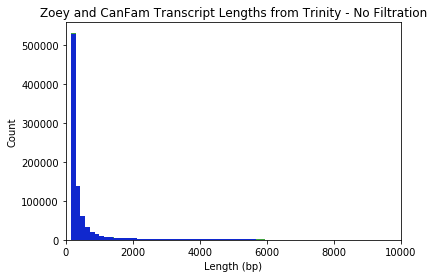

####ZOEY#####
UNFILTERED ZOEY TRINITY TRANSCRIPTS: Minimum transcript length =  151
UNFILTERED ZOEY TRINITY TRANSCRIPTS: Maximum transcript length =  70888
UNFILTERED ZOEY TRINITY TRANSCRIPTS: Mean transcript length =  638.382816839
UNFILTERED ZOEY TRINITY TRANSCRIPTS: Median transcript length =  252.0
####ZOEY#####
UNFILTERED CANFAM TRINITY TRANSCRIPTS: Minimum transcript length =  151
UNFILTERED CANFAM TRINITY TRANSCRIPTS: Maximum transcript length =  70871
UNFILTERED CANFAM TRINITY TRANSCRIPTS: Mean transcript length =  629.922149035
UNFILTERED CANFAM TRINITY TRANSCRIPTS: Median transcript length =  252.0


In [10]:
#Plotting length distributions
zoey_lengths = []

for key in zoeyTrinDict.keys():
    transcriptLength = zoeyTrinDict[key][0]
    zoey_lengths.append(transcriptLength)
    
_ = plt.hist(zoey_lengths, 500, facecolor='green', alpha=0.75, normed=True)
plt.title('Zoey and CanFam Transcript Lengths from Trinity - No Filtration' )
plt.xlabel('Length (bp)')
plt.ylabel('Count')
plt.xlim(0,10000)
plt.show()

print('####ZOEY#####')
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Minimum transcript length = ', min(zoey_lengths))
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Maximum transcript length = ', max(zoey_lengths))
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Mean transcript length = ', np.mean(zoey_lengths))
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Median transcript length = ', np.median(zoey_lengths))



## Zoey CD-HIT-EST Clustering Results for homology/redundancy in transcripts

In [24]:
#path to CD-HIT-EST results on unfiltered Trinity de novo transcripts
cdHitDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/CD-HIT-EST/'

#Levels of c thresholds used to do the % identity clustering using CD-HIT-EST
cValues = [1,99,98]
#Add default 'False' values for next three indices representing each of the three c values
for key in zoeyTrinDict.keys():
    zoeyTrinDict[key].append('False') #c=100%
    zoeyTrinDict[key].append('False') #c=99%
    zoeyTrinDict[key].append('False') #c=98%


#Read through fasta file resulting from each of the three filtrations (c-values)
#   where if a fasta identifier is in this file, then it passed clustering filtration by CD-HIT-EST

################################################################################################
#c = 100%
inFile = cdHitDir + 'Zoey_Trinity_c1.out' 
print('\n##C value = ', 100)
passCount = 0

for line in open(inFile,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        zoeyTrinDict[key][1] = True    
        passCount+=1
    else:
        continue
print('Processed %i ZOEY transcripts that passed at this c-value' % (passCount))

################################################################################################
#c = 99%
inFile = cdHitDir + 'Zoey_Trinity_c99.out' 
print('\n##C value = ', 99)
passCount = 0

for line in open(inFile,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        zoeyTrinDict[key][2] = True 
        passCount+=1
    else:
        continue
print('Processed %i ZOEY transcripts that passed at this c-value' % (passCount))

################################################################################################
#c = 98%
inFile = cdHitDir + 'Zoey_Trinity_c98.out' 
print('\n##C value = ', 98)
passCount = 0

for line in open(inFile,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        zoeyTrinDict[key][3] = True    
        passCount+=1
    else:
        continue
print('Processed %i ZOEY transcripts that passed at this c-value' % (passCount))

################################################################################################
    
#Keep track of dictionary columns added in this cell:
DictHeaders.append(['Remains after 100% ID filtration (CD-HIT-EST) (T/F)','Remains after 99% ID filtration (CD-HIT-EST) (T/F)','Remains after 98% ID filtration (CD-HIT-EST) (T/F)'])



##C value =  100
Processed 900637 ZOEY transcripts that passed at this c-value

##C value =  99
Processed 886221 ZOEY transcripts that passed at this c-value

##C value =  98
Processed 877139 ZOEY transcripts that passed at this c-value


# ZOEY --- RNA-SEQ SUPPORT

## How many Zoey transcripts have expression support in at least one tissue

In [13]:
#Root directory for the RSEM/RNA-Seq assessment for TPM per transcript
rootDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/Alignment_Assessment/results/'

zoey_RNASeqDict,zoey_RNASeqDictHeaders = {}, []
perSampleCounts = []

#Create a new dictionary where it's all the same keys where keys = raw unfiltered de novo transcripts
for key in zoeyTrinDict.keys():
    zoey_RNASeqDict[key] = []


for sample in sampleDict.keys():
    print('\n#SAMPLE: ', sample, ' -- ', sampleDict[sample][0])
    #Clear variables per sample to keep track of how many transcripts are in file, versus how many have expression support
    exp_isoformCount, isoformCount = 0,0 
    
    #Define input files
    inDir = rootDir + sample + '/' #storing the information for each 
    isoformFile = inDir + 'RSEM.isoforms.results'
    
    #Add the sample ID to the header to keep track of which sample applies to each index
    zoey_RNASeqDictHeaders.append(sample)
    
    #Now save expression data for this library to the dictionary
    for line in open(isoformFile,'r'):
        if 'transcript' in line: #skips header
            continue
        line = line.rstrip().split()
        isoformID, effectiveLength, TPM, FPKM, IsoPct = line[0],int(line[2]),float(line[5]),float(line[6]),float(line[7])
        zoey_RNASeqDict[isoformID].append([effectiveLength, TPM, FPKM, IsoPct])
        #keep track of how many isoforms we processed, versus how many have TPM > 1.0
        isoformCount += 1
        if TPM > 1.0:
            exp_isoformCount += 1

    print('%s: %i/%i transcripts with RNA-Seq support TPM > 1.0' % (sample,exp_isoformCount,isoformCount))
    perSampleCounts.append([sample,sampleDict[sample][0],sampleDict[sample][1],exp_isoformCount])
print('DONE!')


#SAMPLE:  SRR388742  --  Ovary
SRR388742: 48091/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388762  --  SmoothMuscle
SRR388762: 19455/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR543735  --  Kidney
SRR543735: 31357/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388748  --  Unidentified
SRR388748: 34396/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388766  --  Brain
SRR388766: 46529/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388759  --  Unidentified
SRR388759: 35203/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388763  --  Lung
SRR388763: 43039/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388738  --  Skin
SRR388738: 34407/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR388737  --  Brain
SRR388737: 46577/903850 transcripts with RNA-Seq support TPM > 1.0

#SAMPLE:  SRR536881  --  Brain
SRR536881: 45856/903850 transcripts with RNA-Seq support 

In [25]:
anyExpression,noExpression,threeSupport = 0, 0, 0 
libraryCounts = []

wkDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/Alignment_Assessment/results/'
outFile = open(expDir + 'PerLibrary_RNASupport_PerZoeyTrinityTranscript.txt','w')
#Write header
outFile.write('Transcript ID\tLength (bp)\tCD-HIT 100% (T/F)\tCD-HIT (99%) (T/F)\tCD-HIT (98%) (T/F)\t')
for i in range(0,len(samples)):
    outFile.write('%s\t' % samples[i])
outFile.write('Libraries With Expression (out of 42)\n')

#Write out per isoform information
for isoformID in zoey_RNASeqDict:
    if len(zoey_RNASeqDict[isoformID]) == 0:
        continue
    #keep track how many RNA-Seq libraries (out of 42) have expression >1.0
    libraryExpCount = 0
    for i in range(0,len(zoey_RNASeqDict[isoformID])):
        #WRITE LENGTH IN BP ONLY FOR FIRST LIBRARY = INDEX==0
        if i == 0:
            length = zoey_RNASeqDict[isoformID][0][0]
            cd1,cd99,cd98 = zoeyTrinDict[isoformID][1],zoeyTrinDict[isoformID][2],zoeyTrinDict[isoformID][3]
            outFile.write('%s\t%s\t%s\t%s\t%s\t' % (isoformID,length,cd1,cd99,cd98))
        #WRITE EXPRESSION DATA 
        TPM, FPKM, IsoPct = zoey_RNASeqDict[isoformID][i][1],zoey_RNASeqDict[isoformID][i][2],zoey_RNASeqDict[isoformID][i][3] 
        outFile.write('%.2f:%.2f:%.2f\t' % (TPM, FPKM, IsoPct))
        if TPM > 1.0:
            libraryExpCount += 1
    #Now that each datapoint has been entered, write how many libraries had expression support and write a new line
    outFile.write('%i\n'%libraryExpCount)
    
    #Keep track of how many had library support
    if libraryExpCount > 0:
        anyExpression += 1
        if libraryExpCount > 2:
            threeSupport += 1
    else:
        noExpression += 1
    libraryCounts.append(libraryExpCount)

outFile.close()

print('%i isoforms had zero transcript support' % noExpression)
print('%i isoforms had transcript support in at least one library' % anyExpression)
print('%i isoforms had transcript support in at least THREE libraries' % threeSupport)

print('Average number of libraries per support == ', np.mean(libraryCounts))
print('Range of library support = %i-%i' % (min(libraryCounts),max(libraryCounts)))

531578 isoforms had zero transcript support
372272 isoforms had transcript support in at least one library
135345 isoforms had transcript support in at least THREE libraries
Average number of libraries per support ==  1.63841455994
Range of library support = 0-42


In [81]:
### Extracting transcript IDs only of those expressed in three or more libraries
cmd = 'awk \'$48 >= 3 {print $1}\' %sPerLibrary_RNASupport_PerZoeyTrinityTranscript.txt | grep -v Transcript > %sExpressedInThreeOrMoreLibraries_TranscriptIDs_Only.txt ' % (expDir,expDir)
print(cmd)
runCMD(cmd)

awk '$48 >= 3 {print $1}' /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/Alignment_Assessment/results/PerLibrary_RNASupport_PerZoeyTrinityTranscript.txt | grep -v Transcript > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/Alignment_Assessment/results/ExpressedInThreeOrMoreLibraries_TranscriptIDs_Only.txt 


# Parsing Zoey BLAT results 

In [11]:
BLATDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/'

#Stats for quality of alignments per genome
zoeySingle,zoeyMulti = 0,0
canfamSingle,canfamMulti = 0,0

noHitFile = open(BLATDir + 'NoHits.txt','w') #file for all transcripts that don't align to genome
inDir = BLATDir + 'results/' #Define path to input files

for i in range(1,92): #goes through output files from split-up BLAT alignments
    blatDict = {}     #Open BLAT dictionary
    print('##### %i' % i) 
    for genome in genomes:
        inFile = inDir + 'BLAT_%s_Zoey_Trinity_%i_sorted.psl' % (genome,i)
        lineCount = 0
        #Clear these per genome ---!!!
        parsedIDs = [] #all hits for this split-blat round
        noAlignment = [] #for transcripts that dont have strong alignment anywhere
        multi_hits = [] #for those that have multiple hits in the genome and no one strong hit >0.9 of length alignment
        HITS,MULTI,NOALIGNMENT = 0,0,0 #tracks number of strong hits and multi-hits per genome 

        for line in open(inFile,'r'):
            line=line.rstrip().split()
            lineCount += 1
            #Skip if line number is less than the 6th line, becuase that's where the data starts
            if len(line) < 10 or 'TRIN' not in line[9]:
                continue
            #__FOR TESTING__#    
            #if lineCount == 999:
            #    break
                
            #read line data
            match, strand, transcriptID = int(line[0]), line[8], line[9]
            chrom,start,end = line[13],int(line[15]),int(line[16])
            transcriptLength = int(line[10])
            propHit = match/float(transcriptLength)
            
            #only accept hits with >90% alignment
            if propHit < .9:
                #if the transcript hasn't been seen before in any other 
                if transcriptID in parsedIDs:
                    continue
                #if transcriptID not in parsedIDs and transcriptID not in noAlignment:
                elif transcriptID not in noAlignment:
                    noAlignment.append(transcriptID)
                    noHitFile.write('%s\t%s\n' % (transcriptID,genome))
                    continue

            #If this transcript hasn't been seen before, create new dictionary structure to store both zoey and canfam hits:
            if transcriptID not in blatDict.keys():
               #blatDict[transcriptID] =  #0-transcriptID,1-zoey_chrom,2-zoey_start,3-zoey_end,4-zoey_transcriptLength,
               #                          #5-zoey_match,6-zoey_alignmentNum,
               #                          #7- cf_chrom, 8-cf_start, 9-cf_end, 10-cf_transcriptLength, 
               #                          #11-cf_match, 12-cf_alignmentNum
                blatDict[transcriptID] = []
                blatDict[transcriptID] = [transcriptID,'','','','','',0,'','','','','',0]
                
            #If not already in the array, this is the top hit!
            if transcriptID not in parsedIDs:
                parsedIDs.append(transcriptID)
                if 'zoey' in genome:
                    blatDict[transcriptID][1],blatDict[transcriptID][2],blatDict[transcriptID][3] = chrom, start, end
                    blatDict[transcriptID][4],blatDict[transcriptID][5],blatDict[transcriptID][6] = transcriptLength, match, 1
                if 'canFam3.1' in genome:
                    blatDict[transcriptID][7],blatDict[transcriptID][8],blatDict[transcriptID][9] = chrom, start, end
                    blatDict[transcriptID][10],blatDict[transcriptID][11],blatDict[transcriptID][12] = transcriptLength, match, 1
                HITS += 1
            else:
                if transcriptID not in multi_hits:
                    multi_hits.append(transcriptID)
                    MULTI += 1
                if 'zoey' in genome:
                    blatDict[transcriptID][6]+=1
                if 'canFam3.1' in genome:
                    blatDict[transcriptID][12]+=1

        
        ####STATS######
        print('###%s, rep #%i ' % (genome,i))
        singleAlignments, multiAlignments = HITS, MULTI
        print('%i top hits' % singleAlignments)
        print('%i transcripts with multiple alignments >90%% of length' % multiAlignments)
        print('%i transcripts were unable to be aligned' % len(noAlignment))
        
        #Global variable to keep track of:
        if 'zoey' in genome:
            zoeySingle,zoeyMulti = zoeySingle + singleAlignments,zoeyMulti+multiAlignments
        else:
            canfamSingle,canfamMulti = canfamSingle + singleAlignments,canfamMulti+multiAlignments
       
    #Write to outfile
    outFile = open(inDir + 'Parsed_BLAT_Zoey_%i.txt' % i, 'w')
    for key in blatDict.keys():
        outFile.write('\t'.join(map(str,blatDict[key])) + '\n')
    outFile.close()    
        
noHitFile.close()
        
print('\n\n\n')
print('#ZOEY')
print('Single hits = ', zoeySingle)
print('Multi alignments = ', zoeyMulti)
print('#CanFam3.1')
print('Single hits = ', canfamSingle)
print('Multi alignments = ', canfamMulti)

##### 1
###zoey-2.3, rep #1 
9905 top hits
882 transcripts with multiple alignments >90% of length
1534 transcripts were unable to be aligned
###canFam3.1-noY, rep #1 
9879 top hits
843 transcripts with multiple alignments >90% of length
1513 transcripts were unable to be aligned
##### 2
###zoey-2.3, rep #2 
9929 top hits
628 transcripts with multiple alignments >90% of length
1085 transcripts were unable to be aligned
###canFam3.1-noY, rep #2 
9826 top hits
634 transcripts with multiple alignments >90% of length
1198 transcripts were unable to be aligned
##### 3
###zoey-2.3, rep #3 
9921 top hits
718 transcripts with multiple alignments >90% of length
1326 transcripts were unable to be aligned
###canFam3.1-noY, rep #3 
9852 top hits
725 transcripts with multiple alignments >90% of length
1399 transcripts were unable to be aligned
##### 4
###zoey-2.3, rep #4 
9933 top hits
735 transcripts with multiple alignments >90% of length
1241 transcripts were unable to be aligned
###canFam3.1-no

###zoey-2.3, rep #30 
9930 top hits
676 transcripts with multiple alignments >90% of length
1274 transcripts were unable to be aligned
###canFam3.1-noY, rep #30 
9826 top hits
691 transcripts with multiple alignments >90% of length
1425 transcripts were unable to be aligned
##### 31
###zoey-2.3, rep #31 
9934 top hits
540 transcripts with multiple alignments >90% of length
991 transcripts were unable to be aligned
###canFam3.1-noY, rep #31 
9893 top hits
489 transcripts with multiple alignments >90% of length
1012 transcripts were unable to be aligned
##### 32
###zoey-2.3, rep #32 
9933 top hits
549 transcripts with multiple alignments >90% of length
974 transcripts were unable to be aligned
###canFam3.1-noY, rep #32 
9846 top hits
687 transcripts with multiple alignments >90% of length
1080 transcripts were unable to be aligned
##### 33
###zoey-2.3, rep #33 
9919 top hits
758 transcripts with multiple alignments >90% of length
1272 transcripts were unable to be aligned
###canFam3.1-no

###zoey-2.3, rep #59 
9955 top hits
585 transcripts with multiple alignments >90% of length
1168 transcripts were unable to be aligned
###canFam3.1-noY, rep #59 
9877 top hits
701 transcripts with multiple alignments >90% of length
1246 transcripts were unable to be aligned
##### 60
###zoey-2.3, rep #60 
9940 top hits
620 transcripts with multiple alignments >90% of length
1213 transcripts were unable to be aligned
###canFam3.1-noY, rep #60 
9871 top hits
640 transcripts with multiple alignments >90% of length
1284 transcripts were unable to be aligned
##### 61
###zoey-2.3, rep #61 
9924 top hits
752 transcripts with multiple alignments >90% of length
1289 transcripts were unable to be aligned
###canFam3.1-noY, rep #61 
9883 top hits
760 transcripts with multiple alignments >90% of length
1356 transcripts were unable to be aligned
##### 62
###zoey-2.3, rep #62 
9932 top hits
603 transcripts with multiple alignments >90% of length
1129 transcripts were unable to be aligned
###canFam3.1-

###zoey-2.3, rep #88 
9912 top hits
605 transcripts with multiple alignments >90% of length
958 transcripts were unable to be aligned
###canFam3.1-noY, rep #88 
9802 top hits
602 transcripts with multiple alignments >90% of length
1078 transcripts were unable to be aligned
##### 89
###zoey-2.3, rep #89 
9940 top hits
941 transcripts with multiple alignments >90% of length
1350 transcripts were unable to be aligned
###canFam3.1-noY, rep #89 
9898 top hits
987 transcripts with multiple alignments >90% of length
1399 transcripts were unable to be aligned
##### 90
###zoey-2.3, rep #90 
9939 top hits
779 transcripts with multiple alignments >90% of length
1421 transcripts were unable to be aligned
###canFam3.1-noY, rep #90 
9899 top hits
825 transcripts with multiple alignments >90% of length
1476 transcripts were unable to be aligned
##### 91
###zoey-2.3, rep #91 
3829 top hits
319 transcripts with multiple alignments >90% of length
529 transcripts were unable to be aligned
###canFam3.1-no

In [84]:
BLATDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/'

#Stats for quality of alignments per genome
zoeySingle,zoeyMulti = 0,0
canfamSingle,canfamMulti = 0,0

inDir = BLATDir + 'results/' #Define path to input files

for i in range(1,92): #goes through output files from split-up BLAT alignments
    blatDict = {}     #Open BLAT dictionary
    print('##### %i' % i) 
    for genome in genomes:
        lineCount = 0
        #Clear these per genome ---!!!
        parsedIDs = [] #all hits for this split-blat round
        inFile = inDir + 'BLAT_%s_Zoey_Trinity_%i_sorted.psl' % (genome,i)
        outFile = open(inDir + 'BLAT_%s_Zoey_Trinity_%i.12.bed' % (genome,i), 'w')
        print(genome)
        for LINE in open(inFile,'r'):
            line=LINE.rstrip().split()
            lineCount += 1

            #Skip if it's not a DATA line
            if len(line) < 10 or 'TRIN' not in line[9]:
                continue
            #__FOR TESTING__#    
            """if lineCount == 100:
                break"""
                
            #read line data
            match, strand, transcriptID = int(line[0]), line[8], line[9]
            chrom,start,end = line[13],int(line[15]),int(line[16])
            transcriptLength = int(line[10])
            blockCount,blockSizes = int(line[17]),str(line[18])
            blocks = str(line[20]).split(',')
            
            BLOCKS = []
            for b in blocks:
                if b == '':
                    continue
                blockStart = int(b) - start 
                BLOCKS.append(blockStart)
            #if len(BLOCKS) > 1:
            #    BLOCKS = ','.join(map(str,BLOCKS)) 
          
            #switch start/stop if the coordinates are flipped
            if start > end:
                END = start
                START = end
            else:
                START = start
                END = end
            
            #only accept hits with >90% alignment that have not already been seen before
            propHit = match/float(transcriptLength)
            if propHit < .9 or transcriptID in parsedIDs:
                continue

            #If not already in the array, this is the top hit!
            parsedIDs.append(transcriptID)
            color = '102,51,153'
            outFile.write('%s\t%i\t%i\t%s\t%i\t%s\t%s\t%s\t%s\t%s\t%s\t%s,\n' % (chrom,START,END,transcriptID,match,strand,start,end,color,blockCount,blockSizes,','.join(map(str,BLOCKS))))
        outFile.close()
    #break
print('\nDONE')

##### 1
zoey-2.3
canFam3.1-noY
##### 2
zoey-2.3
canFam3.1-noY
##### 3
zoey-2.3
canFam3.1-noY
##### 4
zoey-2.3
canFam3.1-noY
##### 5
zoey-2.3
canFam3.1-noY
##### 6
zoey-2.3
canFam3.1-noY
##### 7
zoey-2.3
canFam3.1-noY
##### 8
zoey-2.3
canFam3.1-noY
##### 9
zoey-2.3
canFam3.1-noY
##### 10
zoey-2.3
canFam3.1-noY
##### 11
zoey-2.3
canFam3.1-noY
##### 12
zoey-2.3
canFam3.1-noY
##### 13
zoey-2.3
canFam3.1-noY
##### 14
zoey-2.3
canFam3.1-noY
##### 15
zoey-2.3
canFam3.1-noY
##### 16
zoey-2.3
canFam3.1-noY
##### 17
zoey-2.3
canFam3.1-noY
##### 18
zoey-2.3
canFam3.1-noY
##### 19
zoey-2.3
canFam3.1-noY
##### 20
zoey-2.3
canFam3.1-noY
##### 21
zoey-2.3
canFam3.1-noY
##### 22
zoey-2.3
canFam3.1-noY
##### 23
zoey-2.3
canFam3.1-noY
##### 24
zoey-2.3
canFam3.1-noY
##### 25
zoey-2.3
canFam3.1-noY
##### 26
zoey-2.3
canFam3.1-noY
##### 27
zoey-2.3
canFam3.1-noY
##### 28
zoey-2.3
canFam3.1-noY
##### 29
zoey-2.3
canFam3.1-noY
##### 30
zoey-2.3
canFam3.1-noY
##### 31
zoey-2.3
canFam3.1-noY
##### 32
zoey-2.3

### Merge the final bed files together of all top BLAT hits



In [88]:
for genome in genomes:
    mergedDir = '%s../Merged_BLAT_results/' % inDir
    #Make output directory for the merged BLAT results
    cmd = 'mkdir -p %s' % mergedDir
    print(cmd)
    runCMD(cmd)
    
    #Merge all BLAT results for a given genome
    cmd = 'cat %sBLAT_%s_Zoey_Trinity_*.12.bed > %sTotal_TopHitsOnly_BLAT_%s_Zoey_Trinity.12.bed' % (inDir,genome,mergedDir,genome)
    print(cmd)
    runCMD(cmd)
    
    #Sort the bedfile by position 
    cmd = 'sort -k 1,1 -k 2,2 %sTotal_TopHitsOnly_BLAT_%s_Zoey_Trinity.12.bed > %sTotal_TopHitsOnly_BLAT_%s_Zoey_Trinity_sorted.12.bed' % (mergedDir,genome,mergedDir,genome)
    print(cmd)
    runCMD(cmd)
    
    #Remove the intermediate, only keep sorted for space saving
    cmd = 'rm %sTotal_TopHitsOnly_BLAT_%s_Zoey_Trinity.12.bed' % (mergedDir,genome)
    print(cmd)
    runCMD(cmd)
    
    #Search for only the transcript IDs that were expressed AND had alignment to the genome
    cmd = 'fgrep --file %sExpressedInThreeOrMoreLibraries_TranscriptIDs_Only.txt %sTotal_TopHitsOnly_BLAT_%s_Zoey_Trinity_sorted.12.bed | sort -k 1,1 -k 2,2n > %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_%s_Zoey_Trinity_sorted.12.bed' % (expDir,mergedDir,genome,mergedDir,genome)
    print(cmd)
    runCMD(cmd)
    
    #Make a bigBed file to view on UCSC
    if 'zoey' in genome:
        ChromSizeFile = '~/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes'
    else:
        ChromSizeFile = '~/links/kidd-lab/genomes/canFam3.1/canFam3.1-browser-chrom-sizes.fai'
    cmd = 'bedToBigBed %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_%s_Zoey_Trinity_sorted.12.bed %s %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_%s_Zoey_Trinity_sorted.12.bb' % (mergedDir,genome,ChromSizeFile,mergedDir,genome)
    print(cmd)
    runCMD(cmd)
    

mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/
cat /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/BLAT_zoey-2.3_Zoey_Trinity_*.12.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/Total_TopHitsOnly_BLAT_zoey-2.3_Zoey_Trinity.12.bed
sort -k 1,1 -k 2,2 /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/Total_TopHitsOnly_BLAT_zoey-2.3_Zoey_Trinity.12.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zo

### Find the transcripts that are expressed in one genome and align
### ****BUT**** are missing in the other genome

In [90]:
#Extract transcriptID of those aligned in CanFam
cmd = 'cut -f 4 %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_canFam3.1-noY_Zoey_Trinity_sorted.12.bed ' % mergedDir
cmd += ' | '
cmd += 'fgrep -f - -v %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed ' % (mergedDir)
cmd += ' | '
cmd += 'sort -k 1,1 -k 2,2n > '
cmd += '%sMissingInCanFam_ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed' % mergedDir
print(cmd)
runCMD(cmd)

#Make a bigBed file to view on UCSC
ChromSizeFile = '~/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes'
cmd = 'bedToBigBed %sMissingInCanFam_ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed %s %sMissingInCanFam_ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bb' % (mergedDir,ChromSizeFile,mergedDir)
print(cmd)
runCMD(cmd)

cut -f 4 /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_canFam3.1-noY_Zoey_Trinity_sorted.12.bed  | fgrep -f - -v /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed  | sort -k 1,1 -k 2,2n > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/MissingInCanFam_ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed
bedToBigBed /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/tri

### Find transcripts that are not expressed in Zoey but do have strong alignments

In [96]:
#Extract transcriptID of those aligned in CanFam
#cmd = 'cut -f 4 %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_canFam3.1-noY_Zoey_Trinity_sorted.12.bed ' % mergedDir
cmd = 'cut -f 4 %sExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed ' % mergedDir
cmd += ' | '
cmd += 'fgrep -f - -v %sTotal_TopHitsOnly_BLAT_zoey-2.3_Zoey_Trinity_sorted.12.bed ' % (mergedDir)
cmd += ' | '
cmd += 'sort -k 1,1 -k 2,2n > '
cmd += '%sNOTExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed' % mergedDir
print(cmd)
runCMD(cmd)

#Make a bigBed file to view on UCSC
ChromSizeFile = '~/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes'
cmd = 'bedToBigBed %sNOTExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed %s %sNOTExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bb' % (mergedDir,ChromSizeFile,mergedDir)
print(cmd)
runCMD(cmd)

cut -f 4 /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/ExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed  | fgrep -f - -v /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/Total_TopHitsOnly_BLAT_zoey-2.3_Zoey_Trinity_sorted.12.bed  | sort -k 1,1 -k 2,2n > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLAT/results/../Merged_BLAT_results/NOTExpressedThreeOrMoreRNASeqLibraries_BLAT_TotalTopHits_zoey-2.3_Zoey_Trinity_sorted.12.bed
bedToBigBed /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/zoey-2.3/AllLibraries_trinity/BLA

In [12]:
blatdir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/canFam3.1-noY/AllLibraries_trinity/BLAT/scripts/'
cmdFile = open(blatdir + 'sort_blat_outputs.cmds','w')
for i in range(1,92):
    cmd = 'cat BLAT_zoey-2.3_CanFam_Trinity_%i.psl' % i
    cmd += ' | sort -k 10 -k 1,1g > BLAT_zoey-2.3_CanFam_Trinity_%i_sorted.psl' % i
    cmdFile.write(cmd + '\n')
    cmd = 'cat BLAT_canFam3.1-noY_CanFam_Trinity_%i.psl' % i
    cmd += ' | sort -k 10 -k 1,1g > BLAT_canFam3.1-noY_CanFam_Trinity_%i_sorted.psl' % i
    cmdFile.write(cmd + '\n')
cmdFile.close()

# +++++++++++++++++++++++++++++++++++++++++++

# +++++++++++++++++++++++++++++++++++++++++++

# +++++++++++++++++++++++++++++++++++++++++++

# +++++++++++++++++++++++++++++++++++++++++++

## Reading in ALL CANFAM Trinity transcripts


In [ ]:
fastaFile = open('/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/canFam3.1-noY/AllLibraries_trinity/' + 'Trinity-GG.fasta')
cfTrinDict = {} #to keep track of each Trinity de novo transcript
DictHeaders = [] #to keep track of what data is in each column of the dictionary

for line in fastaFile:
    line=line.rstrip().split()
    if '>' in line[0]:
        ID = line[0].replace('>','')
        length = int(line[1].split('=')[1])
    else:
        continue
    cfTrinDict[ID] = []
    cfTrinDict[ID].append(length)
    
fastaFile.close()

print('%i CanFam Trinity transcripts saved to dictionary' % len(cfTrinDict.keys()))



### Getting unfiltered contig length statistics

In [ ]:
cf_lengths = []

for key in zoeyTrinDict.keys():
    transcriptLength = zoeyTrinDict[key][0]
    zcf_lengths.append(transcriptLength)

    


print('####ZOEY#####')
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Minimum transcript length = ', min(zoey_lengths))
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Maximum transcript length = ', max(zoey_lengths))
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Mean transcript length = ', np.mean(zoey_lengths))
print('UNFILTERED ZOEY TRINITY TRANSCRIPTS: Median transcript length = ', np.median(zoey_lengths))



## CanFam --- Read in expression support

## How many CanFam transcripts have expression support in at least one tissue

## Parse BLAT results


In [14]:
BLATDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Trinity_RNA-Seq_Analysis/trinity_alignments/canFam3.1-noY/AllLibraries_trinity/BLAT/'

#Stats for quality of alignments per genome
zoeySingle,zoeyMulti = 0,0
canfamSingle,canfamMulti = 0,0

noHitFile = open(BLATDir + 'NoHits.txt','w') #file for all transcripts that don't align to genome
inDir = BLATDir + 'results/' #Define path to input files

for i in range(1,91): #goes through output files from split-up BLAT alignments
    blatDict = {}     #Open BLAT dictionary
    print('##### %i' % i) 
    for genome in genomes:
        inFile = inDir + 'BLAT_%s_CanFam_Trinity_%i_sorted.psl' % (genome,i)
        lineCount = 0
        #Clear these per genome ---!!!
        parsedIDs = [] #all hits for this split-blat round
        noAlignment = [] #for transcripts that dont have strong alignment anywhere
        multi_hits = [] #for those that have multiple hits in the genome and no one strong hit >0.9 of length alignment
        HITS,MULTI,NOALIGNMENT = 0,0,0 #tracks number of strong hits and multi-hits per genome 

        for line in open(inFile,'r'):
            line=line.rstrip().split()
            lineCount += 1
            #Skip if line number is less than the 6th line, becuase that's where the data starts
            if len(line) < 10 or 'TRIN' not in line[9]:
                continue
            #__FOR TESTING__#    
            #if lineCount == 999:
            #    break
                
            #read line data
            match, strand, transcriptID = int(line[0]), line[8], line[9]
            chrom,start,end = line[13],int(line[15]),int(line[16])
            transcriptLength = int(line[10])
            propHit = match/float(transcriptLength)
            
            #only accept hits with >90% alignment
            if propHit < .9:
                #if the transcript hasn't been seen before in any other 
                if transcriptID in parsedIDs:
                    continue
                #if transcriptID not in parsedIDs and transcriptID not in noAlignment:
                elif transcriptID not in noAlignment:
                    noAlignment.append(transcriptID)
                    noHitFile.write('%s\t%s\n' % (transcriptID,genome))
                    continue

            #If this transcript hasn't been seen before, create new dictionary structure to store both zoey and canfam hits:
            if transcriptID not in blatDict.keys():
               #blatDict[transcriptID] =  #0-transcriptID,1-zoey_chrom,2-zoey_start,3-zoey_end,4-zoey_transcriptLength,
               #                          #5-zoey_match,6-zoey_alignmentNum,
               #                          #7- cf_chrom, 8-cf_start, 9-cf_end, 10-cf_transcriptLength, 
               #                          #11-cf_match, 12-cf_alignmentNum
                blatDict[transcriptID] = []
                blatDict[transcriptID] = [transcriptID,'','','','','',0,'','','','','',0]
                
            #If not already in the array, this is the top hit!
            if transcriptID not in parsedIDs:
                parsedIDs.append(transcriptID)
                if 'zoey' in genome:
                    blatDict[transcriptID][1],blatDict[transcriptID][2],blatDict[transcriptID][3] = chrom, start, end
                    blatDict[transcriptID][4],blatDict[transcriptID][5],blatDict[transcriptID][6] = transcriptLength, match, 1
                if 'canFam3.1' in genome:
                    blatDict[transcriptID][7],blatDict[transcriptID][8],blatDict[transcriptID][9] = chrom, start, end
                    blatDict[transcriptID][10],blatDict[transcriptID][11],blatDict[transcriptID][12] = transcriptLength, match, 1
                HITS += 1
            else:
                if transcriptID not in multi_hits:
                    multi_hits.append(transcriptID)
                    MULTI += 1
                if 'zoey' in genome:
                    blatDict[transcriptID][6]+=1
                if 'canFam3.1' in genome:
                    blatDict[transcriptID][12]+=1

        
        ####STATS######
        print('###%s, rep #%i ' % (genome,i))
        singleAlignments, multiAlignments = HITS, MULTI
        print('%i top hits' % singleAlignments)
        print('%i transcripts with multiple alignments >90%% of length' % multiAlignments)
        print('%i transcripts were unable to be aligned' % len(noAlignment))
        
        #Global variable to keep track of:
        if 'zoey' in genome:
            zoeySingle,zoeyMulti = zoeySingle + singleAlignments,zoeyMulti+multiAlignments
        else:
            canfamSingle,canfamMulti = canfamSingle + singleAlignments,canfamMulti+multiAlignments
       
    #Write to outfile
    outFile = open(inDir + 'Parsed_BLAT_CanFam_%i.txt' % i, 'w')
    for key in blatDict.keys():
        outFile.write('\t'.join(map(str,blatDict[key])) + '\n')
    outFile.close()    
        
noHitFile.close()
        
print('\n\n\n')
print('#ZOEY')
print('Single hits = ', zoeySingle)
print('Multi alignments = ', zoeyMulti)
print('#CanFam3.1')
print('Single hits = ', canfamSingle)
print('Multi alignments = ', canfamMulti)

##### 1
###zoey-2.3, rep #1 
9913 top hits
844 transcripts with multiple alignments >90% of length
1395 transcripts were unable to be aligned
###canFam3.1-noY, rep #1 
9920 top hits
835 transcripts with multiple alignments >90% of length
1407 transcripts were unable to be aligned
##### 2
###zoey-2.3, rep #2 
9923 top hits
686 transcripts with multiple alignments >90% of length
1236 transcripts were unable to be aligned
###canFam3.1-noY, rep #2 
9889 top hits
666 transcripts with multiple alignments >90% of length
1265 transcripts were unable to be aligned
##### 3
###zoey-2.3, rep #3 
9899 top hits
722 transcripts with multiple alignments >90% of length
1341 transcripts were unable to be aligned
###canFam3.1-noY, rep #3 
9901 top hits
776 transcripts with multiple alignments >90% of length
1405 transcripts were unable to be aligned
##### 4
###zoey-2.3, rep #4 
9914 top hits
815 transcripts with multiple alignments >90% of length
1314 transcripts were unable to be aligned
###canFam3.1-no

###zoey-2.3, rep #30 
9931 top hits
546 transcripts with multiple alignments >90% of length
993 transcripts were unable to be aligned
###canFam3.1-noY, rep #30 
9900 top hits
580 transcripts with multiple alignments >90% of length
1068 transcripts were unable to be aligned
##### 31
###zoey-2.3, rep #31 
9901 top hits
594 transcripts with multiple alignments >90% of length
1112 transcripts were unable to be aligned
###canFam3.1-noY, rep #31 
9935 top hits
602 transcripts with multiple alignments >90% of length
1145 transcripts were unable to be aligned
##### 32
###zoey-2.3, rep #32 
9926 top hits
446 transcripts with multiple alignments >90% of length
847 transcripts were unable to be aligned
###canFam3.1-noY, rep #32 
9901 top hits
520 transcripts with multiple alignments >90% of length
934 transcripts were unable to be aligned
##### 33
###zoey-2.3, rep #33 
9908 top hits
804 transcripts with multiple alignments >90% of length
1359 transcripts were unable to be aligned
###canFam3.1-noY

###zoey-2.3, rep #59 
9947 top hits
578 transcripts with multiple alignments >90% of length
957 transcripts were unable to be aligned
###canFam3.1-noY, rep #59 
9934 top hits
648 transcripts with multiple alignments >90% of length
1004 transcripts were unable to be aligned
##### 60
###zoey-2.3, rep #60 
9935 top hits
708 transcripts with multiple alignments >90% of length
1262 transcripts were unable to be aligned
###canFam3.1-noY, rep #60 
9914 top hits
717 transcripts with multiple alignments >90% of length
1309 transcripts were unable to be aligned
##### 61
###zoey-2.3, rep #61 
9927 top hits
753 transcripts with multiple alignments >90% of length
1328 transcripts were unable to be aligned
###canFam3.1-noY, rep #61 
9901 top hits
782 transcripts with multiple alignments >90% of length
1404 transcripts were unable to be aligned
##### 62
###zoey-2.3, rep #62 
9932 top hits
540 transcripts with multiple alignments >90% of length
979 transcripts were unable to be aligned
###canFam3.1-no

###zoey-2.3, rep #88 
9913 top hits
802 transcripts with multiple alignments >90% of length
1173 transcripts were unable to be aligned
###canFam3.1-noY, rep #88 
9898 top hits
855 transcripts with multiple alignments >90% of length
1222 transcripts were unable to be aligned
##### 89
###zoey-2.3, rep #89 
9931 top hits
712 transcripts with multiple alignments >90% of length
1323 transcripts were unable to be aligned
###canFam3.1-noY, rep #89 
9920 top hits
716 transcripts with multiple alignments >90% of length
1334 transcripts were unable to be aligned
##### 90
###zoey-2.3, rep #90 
8997 top hits
848 transcripts with multiple alignments >90% of length
1286 transcripts were unable to be aligned
###canFam3.1-noY, rep #90 
8988 top hits
868 transcripts with multiple alignments >90% of length
1336 transcripts were unable to be aligned




#ZOEY
Single hits =  891974
Multi alignments =  62594
#CanFam3.1
Single hits =  890786
Multi alignments =  63857
